# Diffusion example

Setup: Install the image library [pillow](https://pillow.readthedocs.io/en/stable/)

~~~bash
pip install pillow
~~~

**Note:** The images in this exercise are of shape `(height, width, RGB channels)`
i.e. y-axis, x-axis, and the 3 colors.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL.ImageOps
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Helper code

In [2]:
def pad_image(input_image, pad):
    # pad image with mirrored values to avoid boundary effects and index errors
    return np.pad(input_image, ((pad, pad), (pad, pad), (0, 0)), mode="reflect")


def print_info(arr):
    print(f"Got array of shape {arr.shape} {arr.dtype} bounds {np.min(arr)} {np.max(arr)}")


def load_image_as_numpy_array(input_file):
    img = Image.open(input_file)
    arr = np.array(img).astype(np.float32)
    print_info(arr)
    return arr


def show_image(img):
    img = np.round(img).astype(int)
    plt.imshow(img)


def add_colorbar(fig, fig_imshow, ax):
    """Add colorbar to a given figure"""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(fig_imshow, cax=cax)

## Load image

Got array of shape (669, 819, 3) float32 bounds 0.0 250.0


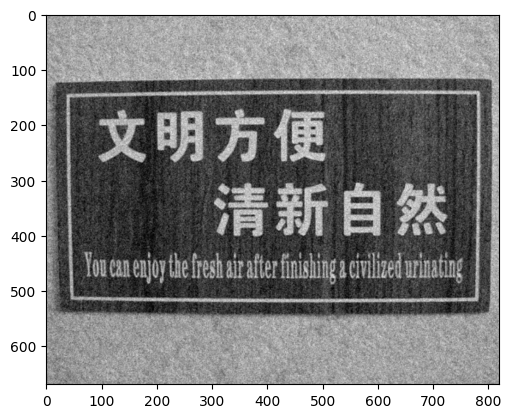

In [3]:
input_file = "diffusion.png"
in_arr = load_image_as_numpy_array(input_file)
arr = np.copy(in_arr)

show_image(arr)

## Homogeneous diffusion

Running homogeneous diffusion with hyperparameters tau=0.1 h=1 n_steps=10


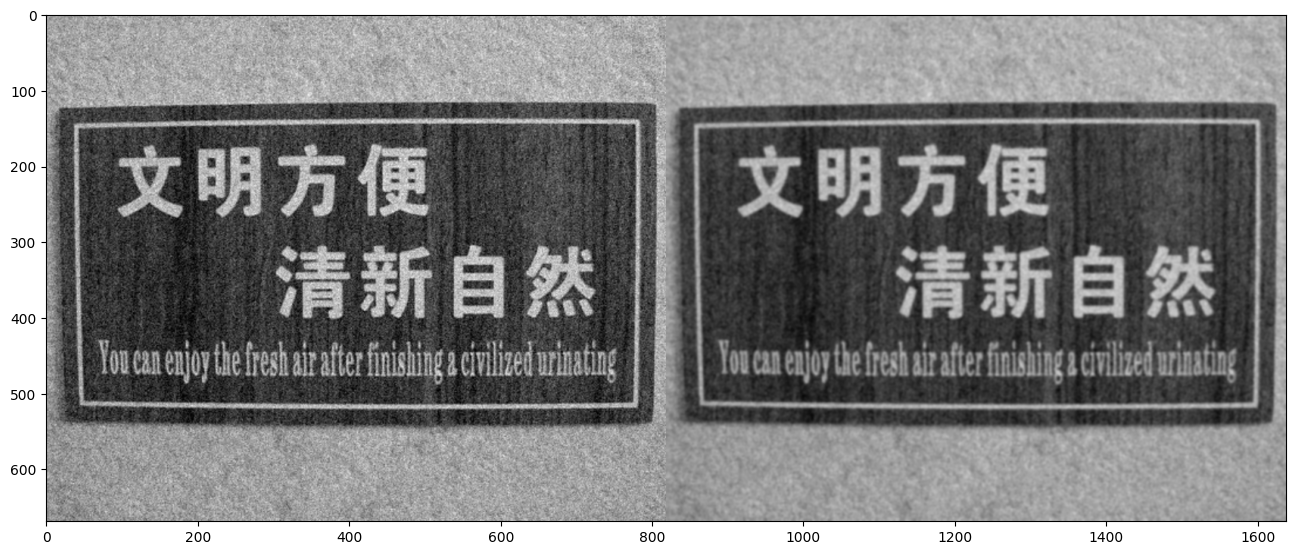

In [4]:
def apply_homogeneous_diffusion_step(input_image, tau, h):
    # pad image to avoid index errors
    padded_image = pad_image(input_image, 1)

    # START TODO #################
    # apply the explicit finite difference scheme
    # new_image = ...
    new_image = input_image * (1 - 4 * tau / h**2) + tau / h**2 * (
        padded_image[1:-1, 2:, :]
        + padded_image[1:-1, :-2, :]
        + padded_image[2:, 1:-1, :]
        + padded_image[:-2, 1:-1, :]
    )
    # END TODO ###################
    return new_image


tau, h, n_steps = 0.1, 1, 10
print(f"Running homogeneous diffusion with hyperparameters " f"tau={tau} h={h} n_steps={n_steps}")
arr_hg = np.copy(in_arr)
for n in range(10):
    arr_hg = apply_homogeneous_diffusion_step(arr_hg, 0.1, 1)

plt.figure(figsize=(16, 8))
both = np.concatenate((in_arr, arr_hg), axis=1)
show_image(both)

## Nonlinear diffusion

Diffusivity:
Got array of shape (669, 819, 3) float32 bounds 3.987436258670811e-37 1.0


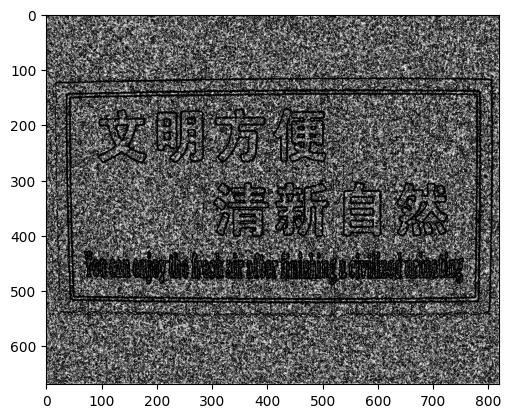

Difference in current step:
Got array of shape (669, 819, 3) float32 bounds 0.0 8.161720275878906


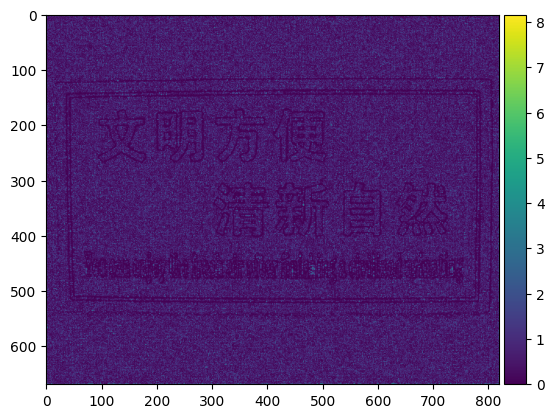

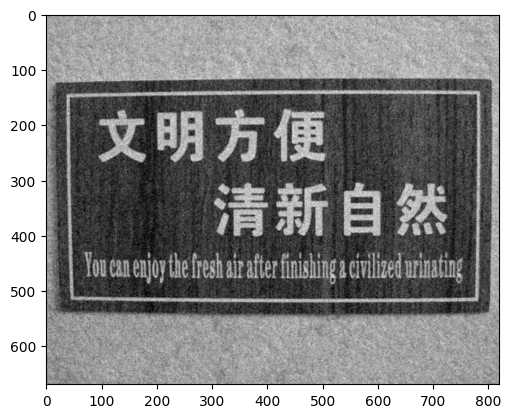

In [5]:
def apply_nonlinear_diffusion_step(input_image, tau, lambd, debug=False):
    # pad image to avoid index errors
    padded_image = pad_image(input_image, 1)

    # START TODO #################
    # apply nonlinear isotropic diffusion with gaussian diffusivity
    # 1. compute diffusivity
    # diffu = ...
    dx_u = (padded_image[1:-1, 2:] - padded_image[1:-1, :-2]) / 2
    dy_u = (padded_image[2:, 1:-1] - padded_image[:-2, 1:-1]) / 2
    grad_squared = dx_u**2 + dy_u**2
    diffu = np.exp(-grad_squared / (lambd**2))
    # END TODO ###################

    if debug:
        print(f"Diffusivity:")
        print_info(diffu)
        plt.imshow(diffu)
        plt.show()

    # pad diffusivity to avoid index errors
    padded_diffu = pad_image(diffu, 1)

    # 2. compute diffusivities between pixels
    diff_x_plus_half = 0.5 * (padded_diffu[1:-1, 2:] + diffu)
    diff_x_minus_half = 0.5 * (padded_diffu[1:-1, :-2] + diffu)
    diff_y_plus_half = 0.5 * (padded_diffu[2:, 1:-1] + diffu)
    diff_y_minus_half = 0.5 * (padded_diffu[:-2, 1:-1] + diffu)

    # START TODO #################
    # 3. implement the explicit scheme
    # new_image = ...
    new_image = (
        1 - tau * (diff_x_plus_half + diff_x_minus_half + diff_y_plus_half + diff_y_minus_half)
    ) * input_image + tau * (
        diff_x_plus_half * padded_image[1:-1, 2:]
        + diff_x_minus_half * padded_image[1:-1, :-2]
        + diff_y_plus_half * padded_image[2:, 1:-1]
        + diff_y_minus_half * padded_image[:-2, 1:-1]
    )
    # END TODO ###################

    if debug:
        print(f"Difference in current step:")
        delta = np.abs(input_image - new_image)
        print_info(delta)
        fig, ax = plt.subplots()
        fig_imshow = plt.imshow(delta.mean(-1))
        add_colorbar(fig, fig_imshow, ax)
        plt.show()

        fig, ax = plt.subplots()
        show_image(new_image)
        plt.show()

    return new_image


arr = np.copy(in_arr)
out_arr = apply_nonlinear_diffusion_step(arr, 0.1, 10, debug=True)

Running nonlinear diffusion with hyperparameters tau=0.1 lambda=10 n_steps=100


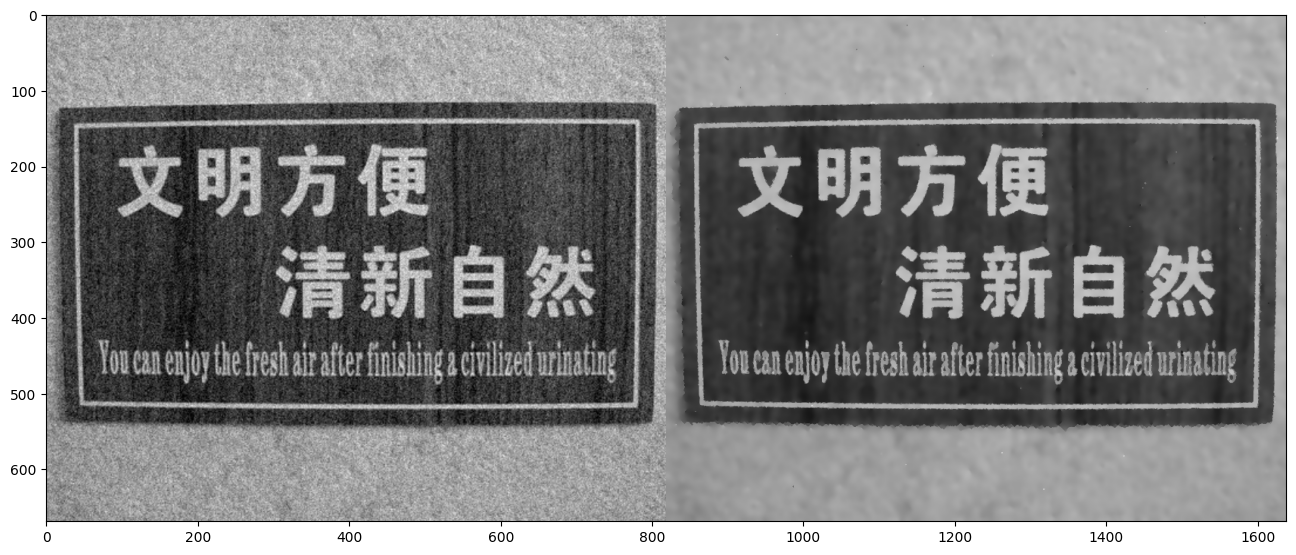

In [6]:
def apply_nonlinear_diffusion(in_arr, tau, lambd, n_steps):
    print(
        f"Running nonlinear diffusion with hyperparameters "
        f"tau={tau} lambda={lambd} n_steps={n_steps}"
    )
    arr_nid = np.copy(in_arr)
    for n in range(n_steps):
        arr_nid = apply_nonlinear_diffusion_step(arr_nid, tau, lambd)
    plt.figure(figsize=(16, 8))
    both = np.concatenate((in_arr, arr_nid), axis=1)
    show_image(both)
    plt.show()


tau = 0.1
lambd = 10
T = 10
n_steps = np.ceil(T / tau).astype(int)

apply_nonlinear_diffusion(in_arr, tau, lambd, n_steps)